In [2]:
import numpy as np
import matplotlib.pyplot as plt

1. Generate Data and split it into training, validation and testing sets

In [3]:
# generate data

x = np.zeros((1506))
x[0] = 1.5

for i in range(1, 1506):
  if (i-25)<0:
    temp = 0
  else:
    temp = x[i-25]
  x[i] = 0.9*x[i-1] + (0.2*temp)/(1+temp**10)

t = np.arange(301, 1501)
input = np.vstack([x[t-20], x[t-15], x[t-10], x[t-5], x[t]])
output = x[t+5]

print("input shape: ", input.shape)

input_train = input[:, :800].T  # First 800 samples for training
input_val = input[:, 800:1000].T  # Next 200 samples for validation
input_test = input[:, 1000:].T  # Remaining 200 samples for testing

output_train = output[:800]  # First 800 outputs for training
output_val = output[800:1000]  # Next 200 outputs for validation
output_test = output[1000:]  # Remaining 200 outputs for testing



input shape:  (5, 1200)


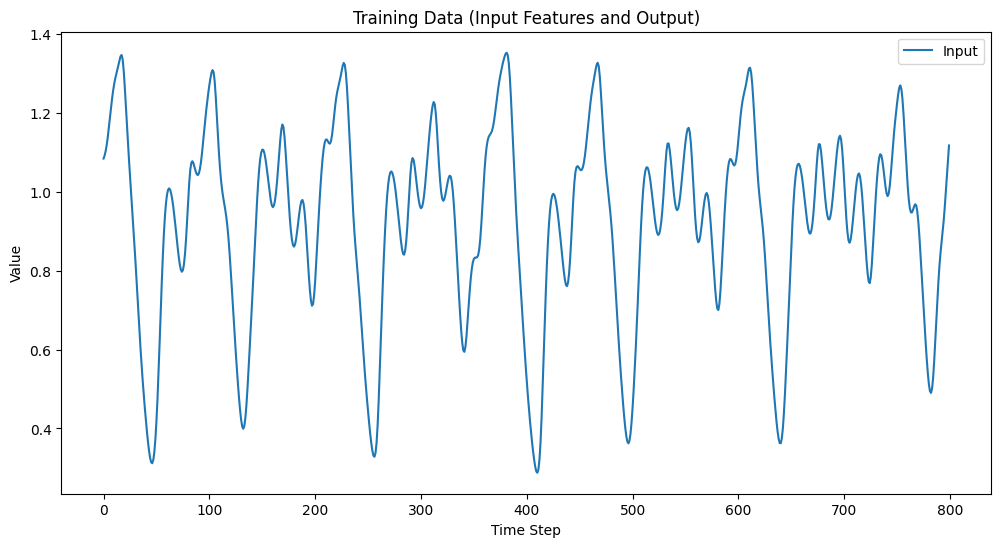

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [22]:
# Plot the input features and outputs for training data
plt.figure(figsize=(12, 6))

# Plot the input features for the training data

plt.plot(np.arange(800), input_train[:, -1], label=f'Input')

# Plot the output for the training data
#plt.plot(np.arange(800), output_train, label='Output', linestyle='--')

plt.title('Training Data (Input Features and Output)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot the input features and outputs for validation data
plt.figure(figsize=(12, 6))

2. Generating models

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

In [6]:
# Define the model-building function
def create_model(nh1, nh2, lr):
    model = Sequential()
    model.add(Dense(nh1, input_dim=5, activation='sigmoid'))  # First hidden layer
    model.add(Dense(nh2, activation='sigmoid'))  # Second hidden layer
    model.add(Dense(1))  # Output layer
    optimizer = Adam(learning_rate=lr)  # Set lr
    model.compile(optimizer=optimizer, loss='mse')  # Using Mean Squared Error loss
    return model


In [7]:
# Define the grid of hidden layer configurations (nh1 x nh2)
grid = [(3, 2), (3, 4), (3, 6),
        (4, 2), (4, 4), (4, 6),
        (5, 2), (5, 4), (5, 6)]

lr = [0.1]

# Track validation loss for each model configuration
results = {}

# Train and evaluate each model configuration
for (nh1, nh2) in grid:
  for l in lr:
      model = create_model(nh1, nh2, l)

      # Early stopping to stop training when validation loss doesn't improve
      early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

      # Train the model
      history = model.fit(input_train, output_train, epochs=100, batch_size=20,
                          validation_data=(input_val, output_val), callbacks=[early_stopping], verbose=0)

      # Evaluate the model on validation data
      val_loss = model.evaluate(input_val, output_val, verbose=0)
      results[nh1, nh2, l] = val_loss
      print(f"Validation loss for architecture ({nh1}, {nh2}) and lr {l}: {val_loss:.6f}")

# Find the best and worst performing models
best_config = min(results, key=results.get)
worst_config = max(results, key=results.get)

print(f"Best performing configuration: {best_config[0], best_config[1]} with lr {best_config[2]} has validation loss {results[best_config]:.6f}")
print(f"Worst performing configuration: {worst_config[0], worst_config[1]} with lr {worst_config[2]} has validation loss {results[worst_config]:.6f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss for architecture (3, 2) and lr 0.1: 0.001023
Validation loss for architecture (3, 4) and lr 0.1: 0.001834
Validation loss for architecture (3, 6) and lr 0.1: 0.000432
Validation loss for architecture (4, 2) and lr 0.1: 0.079127
Validation loss for architecture (4, 4) and lr 0.1: 0.001070
Validation loss for architecture (4, 6) and lr 0.1: 0.001235
Validation loss for architecture (5, 2) and lr 0.1: 0.001301
Validation loss for architecture (5, 4) and lr 0.1: 0.001130
Validation loss for architecture (5, 6) and lr 0.1: 0.001264
Best performing configuration: (3, 6) with lr 0.1 has validation loss 0.000432
Worst performing configuration: (4, 2) with lr 0.1 has validation loss 0.079127


In [8]:
best_config

(3, 6, 0.1)

In [9]:
kfold = KFold(n_splits=4, shuffle=False)
results = []

for train_idx, val_idx in kfold.split(input_train, output_train):
    model = create_model(best_config[0], best_config[1], best_config[2])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(input_train[train_idx], output_train[train_idx], epochs=100, batch_size=20,
              validation_data=(input_train[val_idx], output_train[val_idx]),
              callbacks=[early_stopping], verbose=0)
    val_loss = model.evaluate(input_train[val_idx], output_train[val_idx], verbose=0)
    results.append(val_loss)
    print(val_loss)

print(f"Best model:")
print(f"Mean validation loss across 4 folds: {np.mean(results):.6f}")
print(f"Variance of validation loss across 4 folds: {np.var(results):.6f}")


results = []

for train_idx, val_idx in kfold.split(input_train, output_train):
    model = create_model(worst_config[0], worst_config[1], worst_config[2])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(input_train[train_idx], output_train[train_idx], epochs=100, batch_size=20,
              validation_data=(input_train[val_idx], output_train[val_idx]),
              callbacks=[early_stopping], verbose=0)
    val_loss = model.evaluate(input_train[val_idx], output_train[val_idx], verbose=0)
    results.append(val_loss)
    print(val_loss)

print(f"Worst model:")
print(f"Mean validation loss across 4 folds: {np.mean(results):.6f}")
print(f"Variance of validation loss across 4 folds: {np.var(results):.6f}")

0.0007991703459993005
0.00986096914857626
0.0009583589271642268
0.0007319271680898964
Best model:
Mean validation loss across 4 folds: 0.003088
Variance of validation loss across 4 folds: 0.000015
0.06743375211954117
0.0004959029611200094
0.059489764273166656
0.005849273409694433
Worst model:
Mean validation loss across 4 folds: 0.033317
Variance of validation loss across 4 folds: 0.000920


MSE:  0.0006678274949081242
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


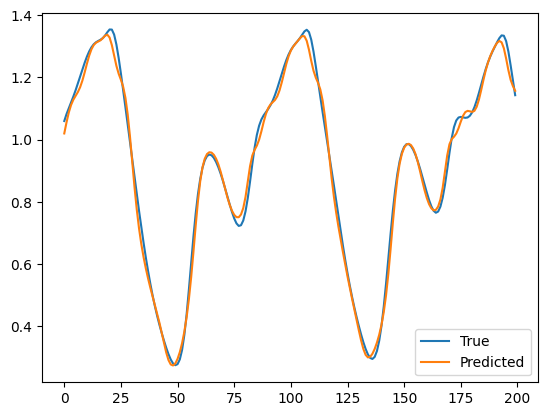

In [10]:
# Testin and plotting best model
model = create_model(best_config[0], best_config[1], best_config[2])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(input_train, output_train, epochs=100, batch_size=20,
                      validation_data=(input_val, output_val), callbacks=[early_stopping], verbose=0)
mse = model.evaluate(input_test, output_test, verbose = 0)
print("MSE: ", mse)
output_pred = model.predict(input_test)

plt.plot(output_test, label='True')
plt.plot(output_pred, label='Predicted')
plt.legend()

MSE:  0.10136443376541138
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


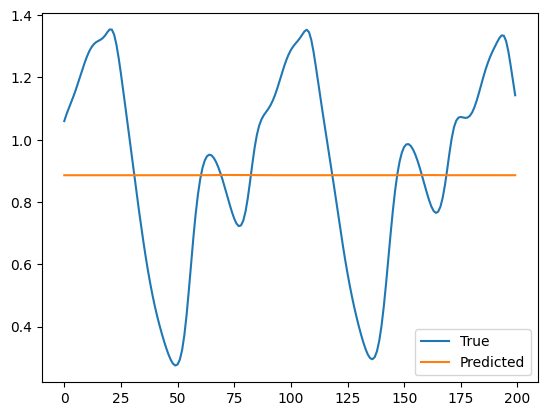

In [11]:
# Testin and plotting worst model
model = create_model(worst_config[0], worst_config[1], worst_config[2])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(input_train, output_train, epochs=100, batch_size=20,
                      validation_data=(input_val, output_val), callbacks=[early_stopping], verbose=0)
mse = model.evaluate(input_test, output_test, verbose = 0)
print("MSE: ", mse)
output_pred = model.predict(input_test)

plt.plot(output_test, label='True')
plt.plot(output_pred, label='Predicted')
plt.legend()

Now lets try regularisation on both


In [12]:
# Define the model-building function with weight decay (L2 regularization)
def create_model_reg(nh1, nh2, lr = 0.1, weight_decay=1e-4):
    model = Sequential()

    # First hidden layer with L2 regularization
    model.add(Dense(nh1, input_dim=input_train.shape[1], activation='sigmoid',
                    kernel_regularizer=regularizers.l2(weight_decay)))

    # Second hidden layer with L2 regularization
    model.add(Dense(nh2, activation='sigmoid',
                    kernel_regularizer=regularizers.l2(weight_decay)))

    # Output layer (no regularization typically)
    model.add(Dense(1))  # Assuming 1 output neuron for regression or binary classification

    # Compile the model with Adam optimizer and MSE loss
    model.compile(optimizer='adam', loss='mse')

    return model


MSE:  0.029736636206507683
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


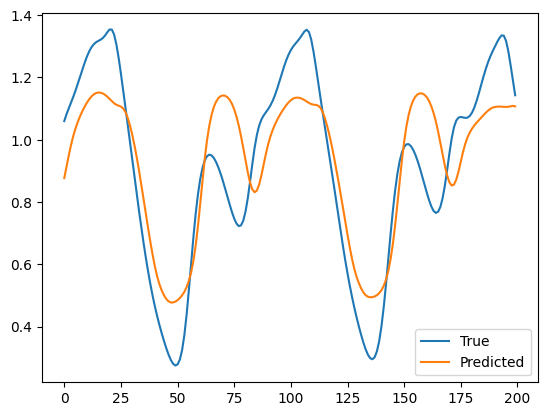

In [13]:
# Testin and plotting best model with l2
weight_decay = 1e-4
model = create_model_reg(best_config[0], best_config[1], best_config[2], weight_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(input_train, output_train, epochs=100, batch_size=20,
                      validation_data=(input_val, output_val), callbacks=[early_stopping], verbose=0)
mse = model.evaluate(input_test, output_test, verbose = 0)
print("MSE: ", mse)
output_pred = model.predict(input_test)

plt.plot(output_test, label='True')
plt.plot(output_pred, label='Predicted')
plt.legend()

MSE:  0.10226627439260483
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


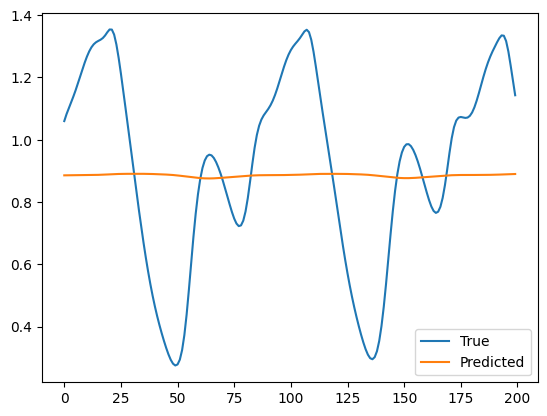

In [14]:
# Testin and plotting worst model with l2
weight_decay = 1e-4
model = create_model_reg(worst_config[0], worst_config[1], worst_config[2], weight_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(input_train, output_train, epochs=100, batch_size=20,
                      validation_data=(input_val, output_val), callbacks=[early_stopping], verbose=0)
mse = model.evaluate(input_test, output_test, verbose = 0)
print("MSE: ", mse)
output_pred = model.predict(input_test)

plt.plot(output_test, label='True')
plt.plot(output_pred, label='Predicted')
plt.legend()

Let's add some Gaussian noise

In [19]:
noise_in = np.random.normal(0, 0.15, input.shape)
noise_out = np.random.normal(0, 0.15, output.shape)

noisy_input = input + noise_in
noisy_output = output + noise_out

noisy_input_train = noisy_input[:, :800].T  # First 800 samples for training
input_val = input[:, 800:1000].T  # Next 200 samples for validation
input_test = input[:, 1000:].T  # Remaining 200 samples for testing

noisy_output_train = noisy_output[:800]  # First 800 outputs for training
output_val = output[800:1000]  # Next 200 outputs for validation
output_test = output[1000:]  # Remaining 200 outputs for testing

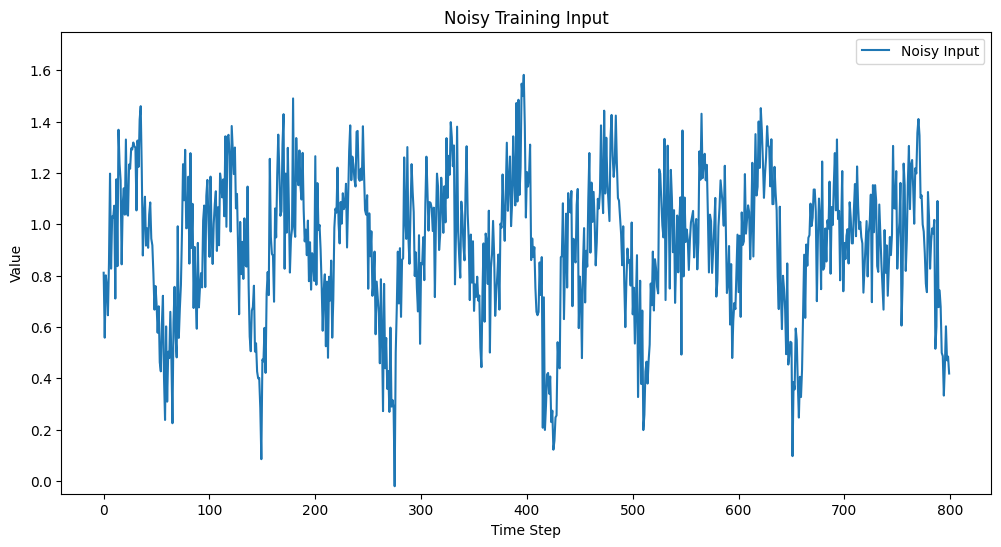

In [20]:
# Plot the noisy training data
plt.figure(figsize=(12, 6))

plt.plot(np.arange(800), noisy_input_train[:, 1], label=f'Noisy Input')

plt.title('Noisy Training Input')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.ylim(-0.05, 1.75)
plt.legend()
plt.show()

MSE:  0.026228301227092743
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
MSE:  0.06527673453092575
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE:  0.0846233144402504
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
MSE:  0.08006580173969269
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE:  0.02676565572619438
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
MSE:  0.03927936032414436
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
MSE:  0.07958181202411652
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
MSE:  0.07960107922554016
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
MSE:  0.026375262066721916
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
MSE:  0.03938519209623337
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE:  0.07982392609119415
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
MSE:  0.07976353913545609
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


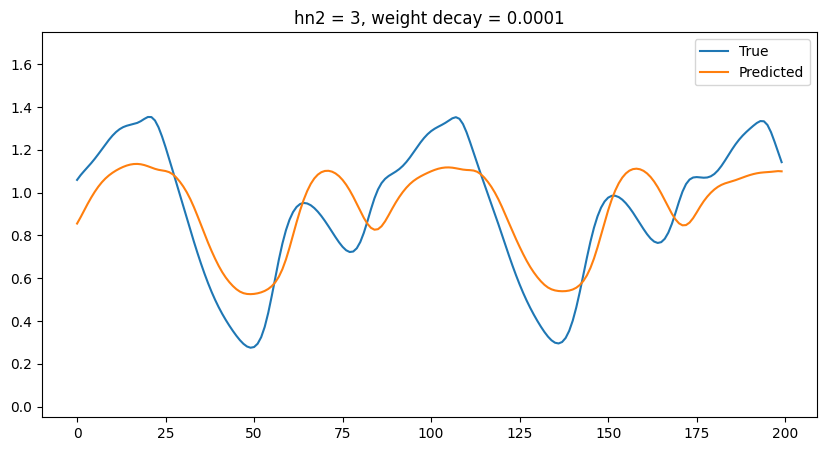

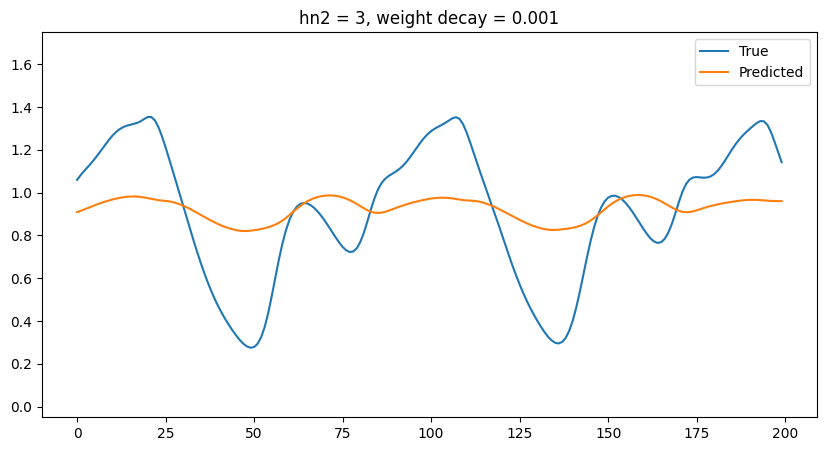

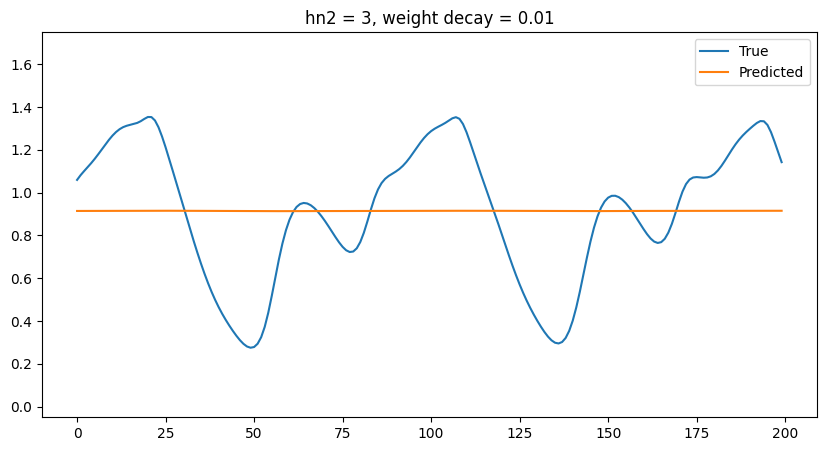

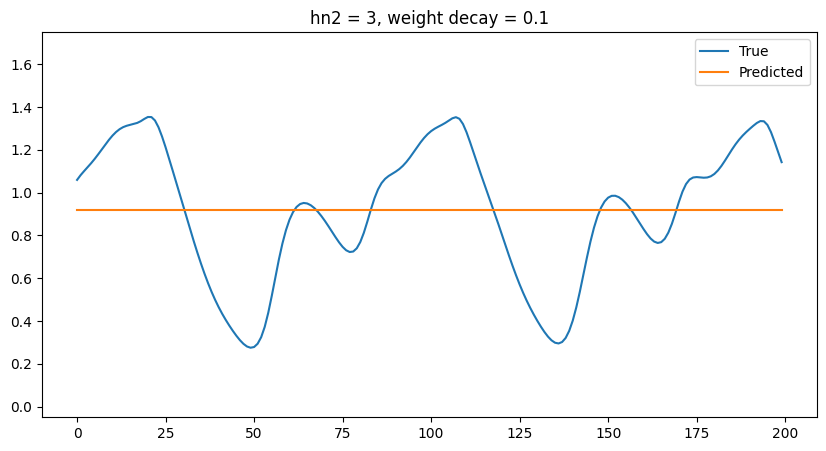

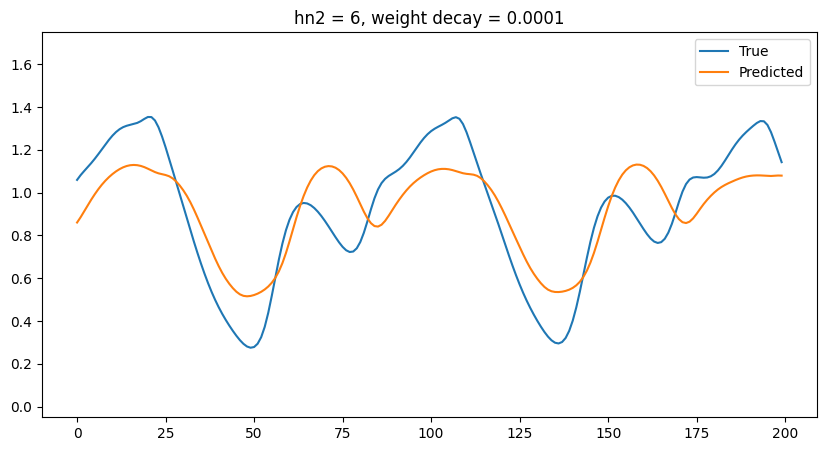

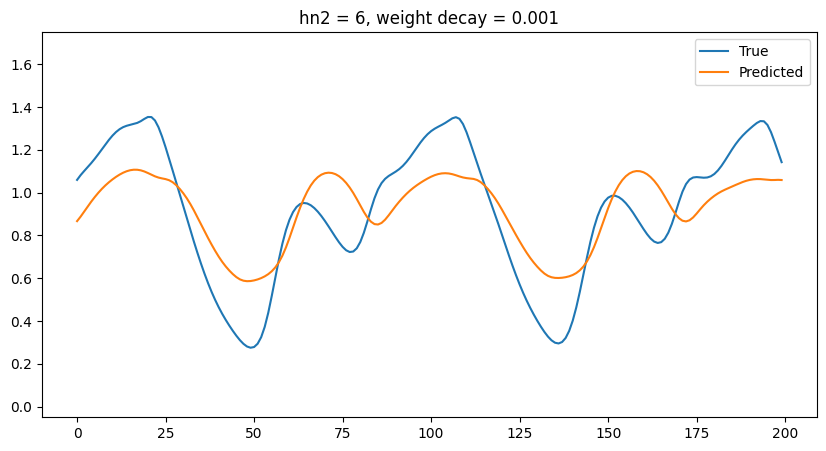

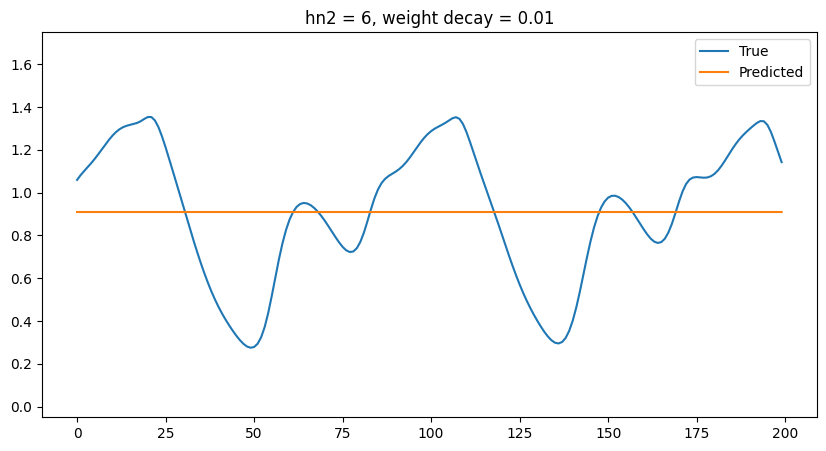

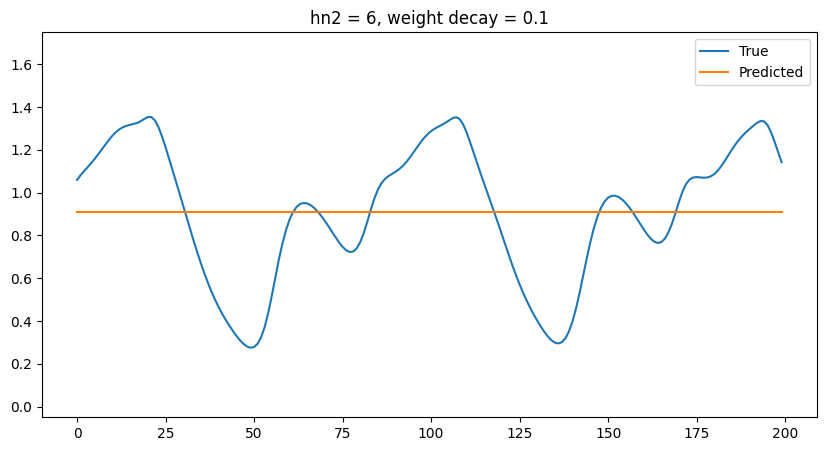

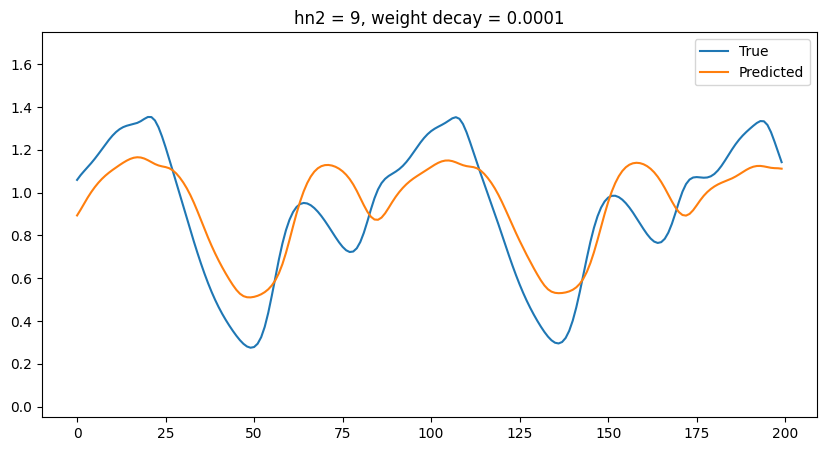

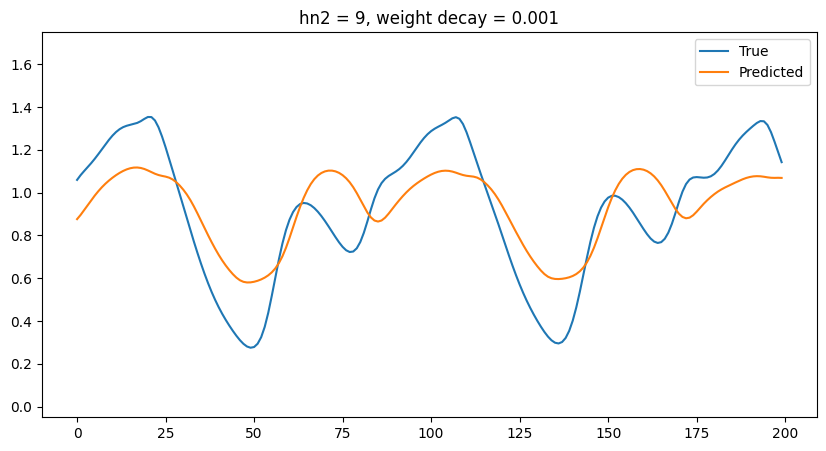

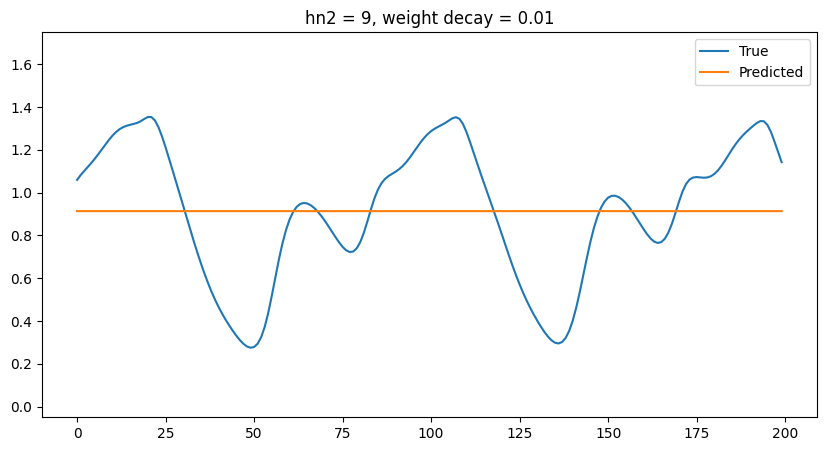

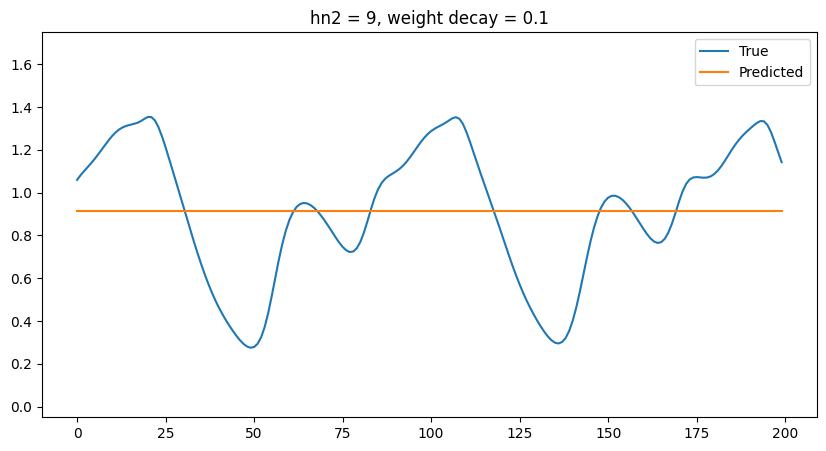

In [21]:
hn2 = [3, 6, 9]
weight_decay = [1e-4, 1e-3, 1e-2, 1e-1]
mse = []
for i in hn2:
  for w in weight_decay:
    model = create_model_reg(best_config[0], i, best_config[2], w)
    history = model.fit(noisy_input_train, noisy_output_train, epochs=100, batch_size=20,
                          validation_data=(input_val, output_val), verbose=0)
    mse.append(model.evaluate(input_val, output_val, verbose = 0))
    print("MSE: ", mse[-1])
    output_pred = model.predict(input_test)

    plt.figure(figsize=(10, 5))
    plt.plot(output_test, label='True')
    plt.plot(output_pred, label='Predicted')
    plt.legend()
    plt.ylim(-0.05, 1.75)
    plt.title(f"hn2 = {i}, weight decay = {w}")